# Abnormal wafer detection in semi-conductor production

The purpose of this notebook is to show the use of the FRESH library in a setting which is unlikely to be influenced by the behaviour of a large number of outside human influences, as is the case in the bike rental and stock market examples.

In the case presented here, the goal is to detect if a wafer is likely to be abnormal/normal given a time-series of features for each wafer. Thus, we can decide if the wafer should be removed from the manufacturing pipeline so that it does not need to be removed at a later date.

---

## Load libraries and data

In the following cell, the kdb+/q machine learning toolkit (ML-Toolkit) is loaded in to allow the use of functions provided in both the FRESH and Utilities sections of the library, including the FRESH algorithm.

The data used here has been loaded and processed post download into its current form from https://www.cs.cmu.edu/~bobski/data/data.html. This is open source data used here as an indication of the use of this algorithm in a manufacturing setting.

In [1]:
\c 15 100
\l ../../ml.q
.ml.loadfile`:init.q
\l graphics.q

/turn off any python warnings
warn:.p.import[`warnings];
warn[`:filterwarnings]["ignore"];

In [2]:
data:("SIIIIIII"; enlist ",") 0:`:SampleDatasets/waferdata.csv
targets:("SI";enlist ",") 0:`:SampleDatasets/wafertargets.csv

Given that this data does not contain null values and is spaced with equi-time there is no requirement for the time column to be present within the data and as such it can be removed from the data.

In [3]:
show 10#data
10#data:delete time from data

id      time feat11 feat12 feat15 feat6 feat7 feat8
---------------------------------------------------
1549_01 0    2      -11    -1     3     24    10   
1549_01 1    2      -11    -1     3     25    10   
1549_01 2    2      -11    0      3     24    10   
1549_01 3    2      -11    -1     3     25    10   
1549_01 4    2      -11    0      3     25    477  
1549_01 5    2      -11    0      3     24    499  
1549_01 6    2      -11    0      3     25    1542 
1549_01 7    2      -11    0      3     24    1869 
1549_01 8    2      -11    0      3     24    2234 
1549_01 9    2      -11    0      3     25    2259 


id      feat11 feat12 feat15 feat6 feat7 feat8
----------------------------------------------
1549_01 2      -11    -1     3     24    10   
1549_01 2      -11    -1     3     25    10   
1549_01 2      -11    0      3     24    10   
1549_01 2      -11    -1     3     25    10   
1549_01 2      -11    0      3     25    477  
1549_01 2      -11    0      3     24    499  
1549_01 2      -11    0      3     25    1542 
1549_01 2      -11    0      3     24    1869 
1549_01 2      -11    0      3     24    2234 
1549_01 2      -11    0      3     25    2259 


The following shows the distribution of the targets within the initial dataset, which gives an indiction of the skew of the dataset. As can be seen appoximately 11% of the initial data contained wafers considered to be abnormal. A determination which would likely have been picked up later in the manufacturing pipeline and thus potentially being costly to the manufacturer.

In [4]:
target:targets`target
update pcnt:100*num%sum num from select num:count i by target from([]target:target)

target| num  pcnt    
------| -------------
0     | 127  10.63652
1     | 1067 89.36348


---

## Feature extraction and selection

To extract features from the FRESH library on the dataset `.ml.fresh.params` must be called. This is a table that contains all the functions along with associated hyperparameters that can be applied to the dataset. These hyperparameters and functions can be altered to suit the use-case in question.

The Benjamini-Hochberg-Yekutieli (BHY) procedure is then applied to determine if features are statistically significant or not.

In [5]:
/ load in the hyperparameter table
ptab:.ml.fresh.params

/ update any function to 0b that has more than 1 hyperparameter
ptab:update valid:0b from ptab where pnum>0

/ change the parameters of a feature
show ptab:update pvals:enlist enlist 1 2 from ptab where f=`spktwelch

f             | pnum pnames pvals valid
--------------| -----------------------
absenergy     | 0                 1    
abssumchange  | 0                 1    
aggautocorr   | 0                 1    
augfuller     | 0                 1    
count         | 0                 1    
countabovemean| 0                 1    
countbelowmean| 0                 1    
fftaggreg     | 0                 1    
firstmax      | 0                 1    
firstmin      | 0                 1    
..


In [6]:
/ produce features based on the unique id's of the data set without using the id column as for feature extraction
5#createdfeatures:.ml.fresh.createfeatures[data;`id;1_cols data;ptab]

id     | feat11_absenergy feat11_abssumchange feat11_count feat11_countabovemean feat11_countbelo..
-------| ----------------------------------------------------------------------------------------..
1549_01| 1.666914e+08     6590                137          98                    39              ..
1549_02| 1.680301e+08     6470                143          99                    44              ..
1549_04| 1.548667e+08     6406                144          98                    46              ..
1549_06| 1.609981e+08     6566                145          98                    47              ..
1549_07| 1.671974e+08     6562                143          99                    44              ..


In [7]:
/ complete feature signif tests on the dataset to only use features deemed to be important to target prediction
5#sigfeattab:key[createdfeatures]!(.ml.fresh.significantfeatures[p;targets[`target];.ml.fresh.benjhoch 0.025])#p:value createdfeatures
-1 "The number of columns in the initial dataset is: ",string count cols data;
-1 "The number of columns in the unfiltered dataset is: ",string count cols createdfeatures;
-1 "The number of columns in the filtered dataset is: ",string count cols sigfeattab;

id     | feat11_stddev feat11_var feat15_countbelowmean feat11_sumrecurringdatapoint feat11_perre..
-------| ----------------------------------------------------------------------------------------..
1549_01| 620.7798      385367.6   86                    111602                       0.6285714   ..
1549_02| 639.4597      408908.7   88                    115077                       0.6451613   ..
1549_04| 622.6771      387726.8   91                    107276                       0.5625      ..
1549_06| 632.2047      399682.8   87                    115185                       0.71875     ..
1549_07| 638.4231      407584.1   86                    116928                       0.6896552   ..


The number of columns in the initial dataset is: 7
The number of columns in the unfiltered dataset is: 277
The number of columns in the filtered dataset is: 186


The following shows that the number of features deemed to be important in the prediction of abnormalities in the manufacturing of the semiconductor wafers is less than the total number of features produced through the `.ml.fresh.createfeatures` procedure, when a threshold of 0.025 is has been applied to the Benjamini-Hochberg-Yekutieli procedures. The reduced number of features should include those that maximize variance in predicting the target, but will improve training and testing times.

In [8]:
-1"The number of extracted features from the dataset is: ",string count cols value createdfeatures;
-1"The number of features deemed significant to prediction is: ",string count cols value sigfeattab;

The number of extracted features from the dataset is: 276
The number of features deemed significant to prediction is: 185


---

## Prepare data for model

In [10]:
mattab:{flip value flip x}

/ Convert the table containing significant features to a matrix in order to allow it to be passed to a machine learning algorithm
featmat:mattab[value sigfeattab]

/ Set a benchmark to be compared against, in this case we use the average value for each feature on each id
benchmark:select avg feat11,avg feat12,avg feat15,avg feat6,avg feat7,avg feat8 by id from data
benchmarktest:mattab[value benchmark]

/ split data into training and testing sets (20% testing)
dict1:.ml.traintestsplit[featmat;targets[`target];.2];
dict2:.ml.traintestsplit[benchmarktest;targets[`target];.2];

---

## Train the model

Below we train a Random Forest Classifier to see if the application of the feature extraction and significance tests have been informative in the prediction of wafer state. This is done by training and making predictions with both data from the naive case, where the assumption is that all wafers being produced are deemed to be normal, and the case where feature extraction and selection have been applied and we look at the final state of a wafer post-production.

Results are presented below in a class report and a confusion matrix.

In [11]:
k:rand 1000
clf:.p.import[`sklearn.ensemble][`:RandomForestClassifier][`n_estimators pykw 500;`random_state pykw k;`verbose pykw 1]

In [12]:
/ filtered data
clf[`:fit][dict1[`xtrain];dict1[`ytrain]]`;
pred1:clf[`:predict][dict1[`xtest]]`
.ml.classreport[dict1[`ytest];pred1]
-1"The number of misclassifications in the filtered dataset is: ",string .ml.sse[dict1[`ytest];pred1];
-1"The accuracy of the filtered dataset is: ",string .ml.accuracy[dict1[`ytest];pred1];

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9354839 1         0.9666667 29     
1        | 1         0.9904762 0.9952153 210    
avg/total| 0.9677419 0.9952381 0.980941  239    


The number of misclassifications in the filtered dataset is: 2
The accuracy of the filtered dataset is: 0.9916318


In [13]:
/ benchmark data
clf[`:fit][dict2[`xtrain];dict2[`ytrain]]`;
pred2:clf[`:predict][dict2[`xtest]]`
.ml.classreport[dict2[`ytest];pred2]
-1"The number of misclassifications in the benchmark dataset is: ",string .ml.sse[dict2[`ytest];pred2];
-1"The accuracy of the benchmark dataset is: ",string .ml.accuracy[dict2[`ytest];pred2];

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9130435 0.9545455 0.9333333 22     
1        | 0.9953704 0.9907834 0.9930716 217    
avg/total| 0.9542069 0.9726644 0.9632025 239    


The number of misclassifications in the benchmark dataset is: 3
The accuracy of the benchmark dataset is: 0.9874477


tn| 29
fp| 0
fn| 2
tp| 208


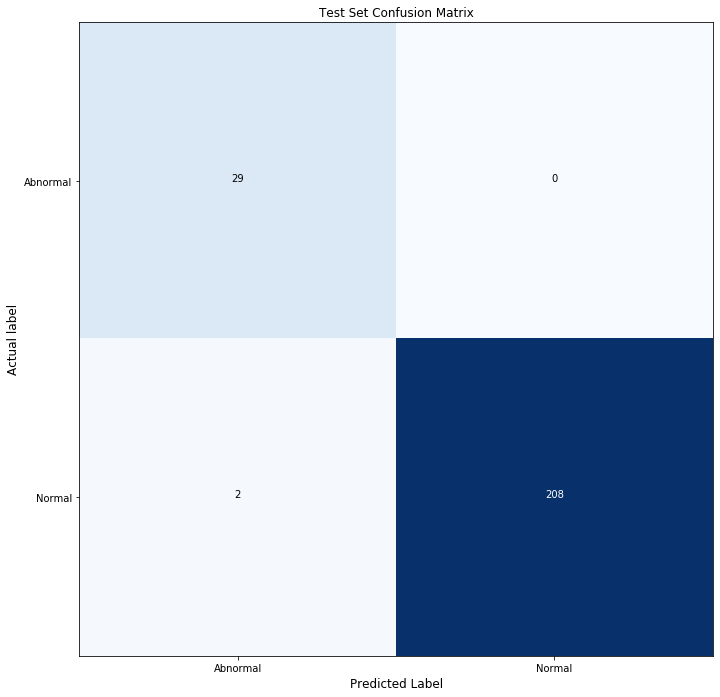

In [14]:
cnfM:.ml.confmat[dict1[`ytest];pred1]
.ml.confdict[dict1[`ytest];pred1;1b]
.ml.displayCM[value cnfM;`Abnormal`Normal;"Test Set Confusion Matrix";()]

---

## Conclusions

It can be seen from multiple runs of the Random Forest Classifier for different seedings and different splits of the dataset that the use of the feature extraction and significance procedures have improved the ability to predict the normality or otherwise of the wafers produced during the manufacturing process.

The accuracy in the case of using the FRESH library produces consistently more accurate results than the benchmark set as the average value being used for the prediction and significantly better results than the naive case where we would assume that all wafers produced are fit for use further down pipeline.

This gives an insight into the potential for the use of this form of analysis in the manufacturing sector particularly given the large volumes of data consistently recorded in modern manufacturing processes.

It also offers the potential for reductions in redundant labour and manufacturing procedures thus reducing the overall cost of the manufacturing pipeline.

---